# Welcome to the OBD SDD BE!

Today, the goal is to understand how a distributed system can be useful when dealing with medium to large scale data sets.  
We'll see that Dask start to be nice as soon as the Data we need to process doesn't quite fit in memory, but also if we
need to launch several computations in parallel.

In this evaluation, you will:
- Use Dask to read and understand the several gigabytes input dataset in a interactive way,
- Preprocess the data in a distributed way: cleaning it up and adding some useful features,
- Launch some model training that can be parallelized on a big dataset,
- Reduce the dataset and train more accurate models on less Data,
- Do an hyper parameter search to find the best model on a small sample of Data.

In order to run and fill this notebook, you'll need to first deploy a Dask enabled Kubernetes cluster as seen before. So please use the Kubernetes_DaskHub notebook for the steps to do it.

Once the Jupyterhub is up, you can clone the OBD repository from a Jupyterlab terminal to get this notebook, and select the default kernel.
```
git clone https://github.com/SupaeroDataScience/OBD.git
cd OBD/notebooks
```

## The Dataset

It is some statistics about NY Taxi cabs. 

See https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview, or https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data.
        
The goal of this evaluation will be to generate a model using machine learning algorithms that will predict the fare amount
of a taxi ride given the other input parameters we have.

The model will be evaluated using the Root mean squared error algorithm:  
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation.

## Try to analyze the Data using Kaggles' start-up code

As an introduction, we'll use Kaggle starters' code to get some insights on the data set and
computations we'll do and measure pandas library (non parallelized access and process) performance.

See https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model where this comes from.

This Kaggle method will set the bar to beat with our own tools. I'm sure you can do it.

#### Reading the data with pandas

We're reading only about 20% from the whole data set.

In [1]:
%%time
import pandas as pd
train_df =  pd.read_csv('gs://obd-dask23/train.csv', nrows = 10_000_000)
train_df.dtypes

CPU times: user 25 s, sys: 3.77 s, total: 28.7 s
Wall time: 45 s


key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

#### Analysing dataset, adding some features and droping null values

Let's see if we can see some correlation between passengers count and fare amount?

In [2]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean()

CPU times: user 177 ms, sys: 16.8 ms, total: 194 ms
Wall time: 191 ms


passenger_count
0       9.047261
1      11.216596
2      11.800345
3      11.536788
4      11.754418
5      11.218924
6      12.141258
7      36.582500
8      32.665000
9      37.366667
34     13.300000
51      9.300000
129     8.500000
208    11.140000
Name: fare_amount, dtype: float64

Maybe adding some features about the distance of the trip could be a good idea?

In [4]:
%%time
# 'abs_diff_longitude' 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

CPU times: user 128 ms, sys: 95.3 ms, total: 223 ms
Wall time: 222 ms


Are there some undefined values?

In [5]:
%%time
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     74
dropoff_latitude      74
passenger_count        0
abs_diff_longitude    74
abs_diff_latitude     74
dtype: int64
CPU times: user 1.15 s, sys: 13.9 ms, total: 1.16 s
Wall time: 1.16 s


We want to get rid of them.

In [6]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999926
CPU times: user 2.07 s, sys: 705 ms, total: 2.77 s
Wall time: 2.77 s


#### Quick analyze on new features and clean outliers

CPU times: user 311 ms, sys: 51.7 ms, total: 363 ms
Wall time: 314 ms


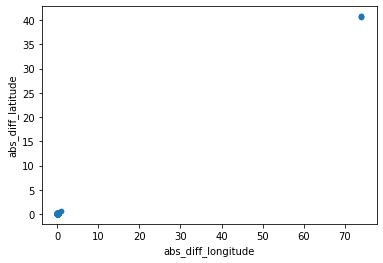

In [7]:
%%time
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

70 degrees longitude seems a bit too high...

In [8]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999926
New size: 9979189
CPU times: user 494 ms, sys: 180 ms, total: 674 ms
Wall time: 670 ms


#### Get training features and results

In [9]:
%%time
import numpy as np

# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(9979189, 3)
(9979189,)
CPU times: user 104 ms, sys: 48.1 ms, total: 152 ms
Wall time: 150 ms


#### Train a simple linear model using Numpy

In [10]:
%%time
# The lstsq function returns several things, and we only care about the actual weight vector w.
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

[148.48697     74.73346376   6.41299165]
CPU times: user 884 ms, sys: 607 ms, total: 1.49 s
Wall time: 793 ms


#### Make prediction on our test set and measure performance

In [11]:
test_df =  pd.read_csv('gs://obd-dask23/test.csv')
test_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [12]:
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)

In [13]:
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

In [14]:
test_y_ref = test_df.fare_amount

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y_ref, test_y_predictions, squared=False)

702.0855518225254

<span style="color:#EB5E0B;font-style:italic">

### Some questions on this first Analysis

- What is the most expensive part of the analysis, the one that takes the most time (see the %%time we used above)?
</span>

Loading the dataset takes the most time, with 20+ seconds, as 2 or 3GB have to be loaded in memory<br>
The 2nd most expensive part is the dropna part, as it has to go through every cell of the dataframe.

<span style="color:#EB5E0B;font-style:italic">
    
- Try to load the whole dataset with Pandas and comment what happens. Can you explain why?
</span>

In [ ]:
del train_df
del train_df_whole

In [ ]:
%%time
train_df_whole =  pd.read_csv('gs://obd-dask23/train.csv')

When we try to load the whole dataset the kernel crashes.<br>
The reason is that our cluster with 1 node is trying to allocate more than the allowed 15GB: we can see the memory going over the allowed 15GB for our cluster with 1 node as pandas is loading the dataset in the RAM.

# Processing our data set using Dask

Dask will help us process all the input data set at once. It is really useful when input data is too big to fit in memory. In this case, it can stream the computation by data chunks on one computer, or distribute the computation on several computers.

This is what we'll do next!

### Start an appropriately sized Dask cluster for our analysis

We'll need a Dask cluster to pre process the data and distribute some learning, the following code starts one in our K8S infrastructure.

**Be sure to have the worker-spec.yaml file next to this notebook.** This should be the case if you cloned the repository.

In [1]:
import dask
import dask.distributed  # populate config with distributed defaults
import dask_kubernetes

dask.config.set({"kubernetes.worker-template-path": "worker-spec.yaml"})
dask.config.set({"distributed.dashboard.link": "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"})

In [2]:
from dask_kubernetes import KubeCluster

cluster = KubeCluster(deploy_mode='local') # Scheduler is started in the notebook process
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://10.80.0.28:46475
distributed.scheduler - INFO -   dashboard at:                     :8787


__Please click on the Dashboard link above, it will help you a lot!__

In [3]:
cluster.scale(10)

In [4]:
from distributed import Client

client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-d8343d35-bdb1-11ed-813c-65129f6d7a2e
distributed.core - INFO - Starting established connection


Connection method: Cluster object,Cluster type: dask_kubernetes.KubeCluster
Dashboard: /user/arthur.laquieze@gmail.com/proxy/8787/status,
Dashboard: /user/arthur.laquieze@gmail.com/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.80.0.28:46475,Workers: 0
Dashboard: /user/arthur.laquieze@gmail.com/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


distributed.scheduler - INFO - Register worker <WorkerState 'tcp://10.80.4.14:40641', name: 7, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.80.4.14:40641
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://10.80.3.15:38353', name: 8, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.80.3.15:38353
distributed.core - INFO - Starting established connection


### Launch some computation, what about Pi?

Just to check our cluster is working!

We'll use Dask array, a Numpy extension for this, we'll also use it later on for the Machine Learning part of this evaluation.

In [5]:
%%time
import dask.array as da

sample = 10_000_000_000  # <- this is huge!
xxyy = da.random.uniform(-1, 1, size=(2, sample))
norm = da.linalg.norm(xxyy, axis=0)
summ = da.sum(norm <= 1)
insiders = summ.compute()
pi = 4 * insiders / sample
print("pi ~= {}".format(pi))

distributed.scheduler - INFO - Register worker <WorkerState 'tcp://10.80.5.8:40037', name: 9, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.80.5.8:40037
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://10.80.1.8:38579', name: 5, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.80.1.8:38579
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://10.80.2.8:41769', name: 3, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.80.2.8:41769
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://10.80.2.9:45885', name: 0, status: undefined, memory: 0, processing: 0>
distributed.sch

pi ~= 3.1416072544
CPU times: user 21.4 s, sys: 1.69 s, total: 23.1 s
Wall time: 51.1 s


## Now, access the data of our BE using Dask

We'll use Dask Dataframe, a distributed version of Pandas Dataframe.

Remember, Dask shares the same API as Pandas.

See https://docs.dask.org/en/latest/dataframe.html.

<br>
<span style="color:#EB5E0B;font-style:italic">
So instead of using Pandas to load the dataset, just use the equivalent dask method from dask.dataframe.

- Fill the following cell (the second one) with the appropriate code to read the data using Dask.
</span>

In [6]:
import dask.dataframe as dd

In [7]:
%%time
## Answer needed here
train_df = dd.read_csv('gs://obd-dask23/train.csv')

CPU times: user 1.22 s, sys: 112 ms, total: 1.33 s
Wall time: 9.25 s


In [8]:
%%time
train_df

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=90,,,,,,,,
,object,float64,object,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


<span style="color:#EB5E0B;font-style:italic">

### Some questions about this data loading

- That was fast for several gigabytes, wasn't it? Why is this, did we really load all the data?
- Why the returned dataframe looks empty?
- See the number of partitions described above? What does it correspond to? (hint, look at the blocksize parameter from https://docs.dask.org/en/latest/generated/dask.dataframe.read_csv.html). You might also get a more precise idea of what this number corresponds to with the next code execution.
</span>

- that was fast: as dask.dataframe is lazy it does not actually load the data from the CSV, only the columns, dtypes etc.
- the returned dataframe looks empty as it's not loaded in memory yet. To do that you have to use .compute()
- the partition is the number of pieces / chunks the whole dataframe has been divided into. We have 90 chunks and a dataset of 5.7GB, so each block is 5.7GB / 90 = 64MB, which is exactly the maximum auto-computed blocksize as stated by the documentation.

## Little warm up: Analyzing our data to better understand it

<span style="color:#EB5E0B;font-style:italic">

- First, how many records do we have? (hint, in python, len() works for almost any object).
</span>

In [17]:
%%time
len(train_df)

CPU times: user 2.88 s, sys: 234 ms, total: 3.11 s
Wall time: 12.6 s


55413856

<span style="color:#EB5E0B;font-style:italic">
    
- What did happend when counting record of our Dask dataframe (as opposed to with only the `read_csv` call? Remember with the Spark tutorial: transformations and actions... Same kind of concepts exist in Dask. Just look at the Dask Dashboard!
</span>

It's taking quite some time calling the \_\_len\_\_ attribute of the Dask dataframe, as it builds the computation graph and computes it, as opposed to read_csv that only builds the computation graph.<br><br>
The computation graph in short: when calling len() the workers have to load the dataset with `s = self.iloc[:, 0] ; return len(s)` for each chunk, thus calling \_\_getitem\_\_ on each row. Then it aggregates each worker's chunk len, and sums it to have the dataset length. We can see on the dashboard that the \_\_getitem\_\_ is taking most of the time, as the aggregation is straiteforward.

<span style="color:#EB5E0B;font-style:italic">
    
- Compare the time of this computation to the time of loading a subset of the Dataset with Pandas. Was it fast enough considering the number of workers we have?
    
I recommend trying to calculate an estimation of the time it would take with Pandas to read the entire dataset, and **total processing** time (not only the walltime) it took for every dask workers.
</span>

In [9]:
import pandas as pd

In [26]:
%%time
train_df_pandas =  pd.read_csv('gs://obd-dask23/train.csv', nrows = 10_000_000)

CPU times: user 29 s, sys: 4 s, total: 33 s
Wall time: 37.5 s


In [27]:
%%time
train_df_pandas.__len__()

CPU times: user 22 µs, sys: 1e+03 ns, total: 23 µs
Wall time: 27.7 µs


10000000

As the time to compute len on a loaded pd dataframe is negligeable, let's assume most of the time would be taken by loading it.<br>
Dask took 12.5s with 10 workers and 20 threads (at maximum), thus the equivalent time with one worker would be 250s. We would expect pandas to take the same time to load the dataset.<br>
Pandas takes 37.5s to load ~10/55 of the dataset on one thread, so we can expect it to take 206s to load the whole dataset and compute the length.<br><br>
So dask was clearly fast enough, loosing only 42s - 20% of total processing time over pandas, while having to aggregate and managing the workers that cannot be busy at all time, especially at the end of the computation.

Let's have a look at some data:

In [10]:
%%time
train_df.head()

CPU times: user 513 ms, sys: 45.4 ms, total: 559 ms
Wall time: 3.15 s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-10-12 23:47:39.0000002,9.00,2014-10-12 23:47:39 UTC,-73.973863,40.764248,-73.986874,40.736618,1
1,2012-08-17 22:34:00.000000118,4.10,2012-08-17 22:34:00 UTC,-73.997062,40.722330,-73.997642,40.729135,1
2,2011-05-17 13:11:00.000000229,9.70,2011-05-17 13:11:00 UTC,-74.000002,40.727167,-73.984253,40.753135,2
3,2015-03-08 09:10:25.0000005,57.33,2015-03-08 09:10:25 UTC,-74.004166,40.737652,-73.795753,40.644497,2
4,2010-03-27 19:54:44.0000001,7.30,2010-03-27 19:54:44 UTC,-73.990309,40.751309,-73.980597,40.761481,1


<span style="color:#EB5E0B;font-style:italic">
    
- Why was it faster than counting all the records above? 
- What did we actualy read? You might want to look at the Dashboard for some hinsights. Remember that Dask laziness is not only about transformations and actions, but optimizing the computations needed.
</span>

- It was faster, as when calling the `.head()`, only the worker in charge of the 1st chunk of the data has to load it. 
- Only the first chunk of the csv was read as that's the only thing needed for `.head()`.

<span style="color:#EB5E0B;font-style:italic">
    
- Let's compute the mean of the fare amount given the passengers count, **as we've done with Pandas above**. Please fill the blank. (hint: Dask is the same as pandas, but often with a `compute()` call at the end)
</span>

In [19]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean().compute()

CPU times: user 4.2 s, sys: 350 ms, total: 4.55 s
Wall time: 17.7 s


passenger_count
0       9.015400
1      11.216398
2      11.838426
3      11.540684
4      11.766121
5      11.208482
6      12.126306
8      29.981111
208     8.975000
51      9.300000
129     8.900000
7      31.788667
9      36.993043
34     13.300000
49      2.500000
Name: fare_amount, dtype: float64

Wow, ever seen a cab with more than **200 people**?? Americans are crazy. And it's cheap...

<br>

<span style="color:#EB5E0B;font-style:italic">

- This computation is slow, especially compared with Pandas, why? (Look a the Dashboard, again).
- Which part of the computation is slow, look at the Dashboard to see the name of the tasks. Hint, this is the same as Pandas.
</span>

- the computation is slow as it has to load the dataset for each task, aggregate the groupby, then run the mean computation, aggregate, ...
- The slowest part is the readcsv call that each worker uses to load its chunks.

<span style="color:#EB5E0B;font-style:italic">
    
- How could we optimize the next computations, using which Dask method? Same as Spark...
- Where will be the data at the end of the computation triggered by this call?
</span>

- As with dask we can persit train_df with `train_df.persist()` which will keep the chunks in memory of the workers and avoid reloading the csv each time.
- at the end the data will be on the scheduler, which is started in the notebook process

<span style="color:#EB5E0B;font-style:italic">
    
- Look at the Dashboard at what is happening beind the scene.
    
Wait for the end of this call on the Dashboard, then try again the previous computation on fare_amout.mean():
</span>

In [11]:
%%time
train_df = train_df.persist()

CPU times: user 16.6 ms, sys: 1.97 ms, total: 18.6 ms
Wall time: 17.3 ms


In [13]:
%%time 
train_df.groupby(train_df.passenger_count).fare_amount.mean().compute()


CPU times: user 348 ms, sys: 27.6 ms, total: 376 ms
Wall time: 411 ms


passenger_count
0       9.015400
1      11.216398
2      11.838426
3      11.540684
4      11.766121
5      11.208482
6      12.126306
8      29.981111
208     8.975000
51      9.300000
129     8.900000
7      31.788667
9      36.993043
34     13.300000
49      2.500000
Name: fare_amount, dtype: float64

Much better isn't it?

## Let's do some preprocessing of our data to clean it up and add some features

<br>

<span style="color:#EB5E0B;font-style:italic">
- You'll need to do the same operations as in pandas, we just need to call compute when needing a result, and not compute when building our dataframe transformations.
</span>

<span style="color:#EB5E0B;font-style:italic">

#### Cleaning up

- Is there some null values in our data?
</span>

In [23]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-10-12 23:47:39.0000002,9.00,2014-10-12 23:47:39 UTC,-73.973863,40.764248,-73.986874,40.736618,1
1,2012-08-17 22:34:00.000000118,4.10,2012-08-17 22:34:00 UTC,-73.997062,40.722330,-73.997642,40.729135,1
2,2011-05-17 13:11:00.000000229,9.70,2011-05-17 13:11:00 UTC,-74.000002,40.727167,-73.984253,40.753135,2
3,2015-03-08 09:10:25.0000005,57.33,2015-03-08 09:10:25 UTC,-74.004166,40.737652,-73.795753,40.644497,2
4,2010-03-27 19:54:44.0000001,7.30,2010-03-27 19:54:44 UTC,-73.990309,40.751309,-73.980597,40.761481,1


In [16]:
## Answer needed here
## check after running the cell bellow
train_df.isnull().sum().compute()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

<span style="color:#EB5E0B;font-style:italic">
    
- Yep! We must get rid of them...
</span>

In [15]:
## Answer needed here
train_df = train_df.dropna(how = 'any').persist()

#### Adding features

<span style="color:#EB5E0B;font-style:italic">

- As with Pandas above, add the latitude and longitude distance vector with a function call
</span>

In [17]:
## Answer needed here. We define a function here, cause we'll need to apply it on our test dataframe too later on!
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs().persist()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs().persist()


In [18]:
add_travel_vector_features(train_df)

A quick look at our Dataframe to check things

In [19]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2014-10-12 23:47:39.0000002,9.00,2014-10-12 23:47:39 UTC,-73.973863,40.764248,-73.986874,40.736618,1,0.013011,0.027630
1,2012-08-17 22:34:00.000000118,4.10,2012-08-17 22:34:00 UTC,-73.997062,40.722330,-73.997642,40.729135,1,0.000580,0.006805
2,2011-05-17 13:11:00.000000229,9.70,2011-05-17 13:11:00 UTC,-74.000002,40.727167,-73.984253,40.753135,2,0.015749,0.025968
3,2015-03-08 09:10:25.0000005,57.33,2015-03-08 09:10:25 UTC,-74.004166,40.737652,-73.795753,40.644497,2,0.208412,0.093155
4,2010-03-27 19:54:44.0000001,7.30,2010-03-27 19:54:44 UTC,-73.990309,40.751309,-73.980597,40.761481,1,0.009712,0.010172


<span style="color:#EB5E0B;font-style:italic">
    
- Now let's quickly plot a subset of our travel vector features to see its distribution. Use dask.dataframe.sample() to get about 1 percent of the rows, and get it back with compute and plot as we've done it with Pandas
</span>

In [20]:
import matplotlib.pyplot as plt

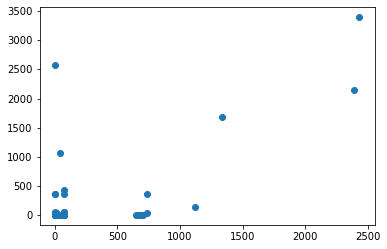

CPU times: user 2.9 s, sys: 367 ms, total: 3.27 s
Wall time: 3.37 s


In [21]:
%%time
subset_df = train_df.sample(frac=0.01)

x, y = subset_df["abs_diff_longitude"], subset_df["abs_diff_latitude"]

plt.scatter(x, y)
plt.show()

Wow, looks like we have some strange values here: more than 1000° of distance... There's a problem somewhere.

<br>

<span style="color:#EB5E0B;font-style:italic">
- Just get rid of the extreme values, we should keep only values inside the city wall or so. Like with Pandas above...
</span>

In [22]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)].persist()
print('New size: %d' % len(train_df))

Old size: 55413480
New size: 55298943
CPU times: user 1.22 s, sys: 71.6 ms, total: 1.29 s
Wall time: 2.43 s


<span style="color:#EB5E0B;font-style:italic">

- you can do another plot like above with the filtered values if you like.
</span>

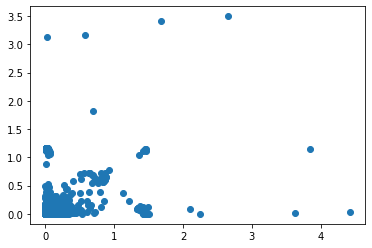

In [23]:
## Answer needed here
subset_df = train_df.sample(frac=0.01)

x, y = subset_df["abs_diff_longitude"], subset_df["abs_diff_latitude"]

plt.scatter(x, y)
plt.show()

Ok, let's see some statistics on our Dataset. The describe() function inherited from Pandas compute a lot of statistics on a dataframe.

In [24]:
train_df.describe().compute()

distributed.utils_perf - INFO - full garbage collection released 29.26 MiB from 6520 reference cycles (threshold: 9.54 MiB)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
count,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07
mean,1.133683e+01,-7.257290e+01,3.995280e+01,-7.257205e+01,3.995314e+01,1.685440e+00,2.251316e-02,2.110157e-02
std,2.071499e+01,1.094742e+01,7.044005e+00,1.094731e+01,7.044055e+00,1.326790e+00,3.854502e-02,2.903143e-02
min,-3.000000e+02,-3.440696e+03,-3.488080e+03,-3.440696e+03,-3.488080e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399201e+01,4.073514e+01,-7.399136e+01,4.073480e+01,1.000000e+00,5.826000e-03,7.097500e-03
50%,8.500000e+00,-7.398174e+01,4.075281e+01,-7.397989e+01,4.075331e+01,1.000000e+00,1.244800e-02,1.387000e-02
75%,1.250000e+01,-7.396704e+01,4.076762e+01,-7.396365e+01,4.076842e+01,2.000000e+00,2.370100e-02,2.696945e-02
max,9.396336e+04,3.456223e+03,3.378013e+03,3.456223e+03,3.378013e+03,2.080000e+02,4.989833e+00,4.991325e+00


<span style="color:#EB5E0B;font-style:italic">
    
- Find some values (at least two) that still looks odd to you in the table above.
</span>

The min row with min passenger_count and distances of 0 is odd. Also a minimum fare of -300$ is very odd. A maximum number of 208 passengers is odd too unless planes are considered cabs in NY. We should filter that out. 

<span style="color:#EB5E0B;font-style:italic">
    
### BONUS Questions (you don't have to do this, just go back to it if you want to improve, skip it at first)

Some other questions to practice

- Can you see a correlation between the fare amount and the dropoff latitude? Answer by doing a dask dataframe computation.

First you'll need to round the dropoff latitude to have some sort of categories using Series.round() function.

Then, just group_by this new colon to have some answer (and don't forget to compute to get the results).
</span>

In [ ]:
## Answer needed here

OK, this don't give a lot of insights, but it looks like we've got some strange values somewhere!

<br>

<span style="color:#EB5E0B;font-style:italic">
- Let's just have a look of non extreme values, so probably some records at the middle of the results.
We need first to sort the resulting series by index before looking at the middle of it.
</span>

In [ ]:
## Answer needed there

OK, this is not really useful, but it's an exercise!

<span style="color:#EB5E0B;font-style:italic">
    
- Do you think we could parallelize things better for any of our computation or data access? (It's a trap).
</span>

In [ ]:
## Textual answer needed here

## Training a model in a distributed way

Let's begin with a linear model that we can distributed with Dask ML.

### Building our feature vectors

Here again define a method so that we can use it later for our test set evaluation.

<br>

<span style="color:#EB5E0B;font-style:italic">
    
- Just do the same as with the Pandas example by defining a get_input_matrix(df) function. But this time you'll generate a dask array (not numpy) using `to_dask_array(lengths=True)` method on the dataframe object instead of `np.column_stack` (look a bit a dask docs in order to find how to use this method). You should do a method that generate the X input features dask array, and also the same with y training results. You can do just one method that return both (return X, y). 
- It is a good idea to persist() arrays in memory in or after the call.
- This time, we'll add the feature 'passenger_count' in addition to the distance vectors, one more feature! So X must have 3 columns.
</span>

In [25]:
## Answer needed here

# using the travel vector, plus passenger count.
def get_input_matrix(df):
    x = df[["abs_diff_longitude", "abs_diff_latitude", "passenger_count"]].to_dask_array(lengths=True)
    y = df["fare_amount"].to_dask_array(lengths=True)
    return x.persist(), y.persist()


Then we get the values, and display train_X to have some insights of its size and chunking scheme.

In [30]:
train_X, train_y = get_input_matrix(train_df)
train_X

dask.array<values, shape=(55298943, 3), dtype=float64, chunksize=(621536, 3), chunktype=numpy.ndarray>

### Distributed training a Linear model

Be careful, this can take time, try first with few iterations (Use max_iter = 5 as a kwarg to LinearRegression constructor).

see https://ml.dask.org/glm.html  
and https://ml.dask.org/modules/generated/dask_ml.linear_model.LinearRegression.html#dask_ml.linear_model.LinearRegression

<br>

<span style="color:#EB5E0B;font-style:italic">
    
- Train a LinearRegression model from dask_ml.linear_model on our inputs
</span>


In [27]:
from dask_ml.linear_model import LinearRegression


In [31]:
%%time

lr = LinearRegression(max_iter=5)

lr.fit(train_X, train_y)


CPU times: user 6.58 s, sys: 466 ms, total: 7.05 s
Wall time: 14.6 s


LinearRegression(max_iter=5)

## Evaluating our model


#### First we should load the test set.

In [94]:
test_df = dd.read_csv('gs://obd-dask23/test.csv')
test_df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=1,,,,,,,,
,object,float64,object,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...


Adding our features to the test set and getting our feature array

In [95]:
add_travel_vector_features(test_df)
test_X, test_y = get_input_matrix(test_df)
test_X

dask.array<values, shape=(10000, 3), dtype=float64, chunksize=(10000, 3), chunktype=numpy.ndarray>

We can use the score method inherited from Scikit learn, it gives some hints on the model performance (but our scoring board will be on RMSE). Even if for linear models, score if often low.

In [34]:
lr.score(test_X, test_y)

-5446.859716263979

In [35]:
lr.predict(test_X).compute()

array([32.00397982, 10.425151  , 13.43535835, ...,  8.44537463,
       10.06470166,  7.21376595])

#### Compute the RMSE

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

In [36]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y.compute(), lr.predict(test_X).compute(), squared=False)

704.4395891068963

<span style="color:#EB5E0B;font-style:italic">
    
- What RMSE did you get? Compare it to the Pandas only computation.
</span>

We find a similar RMSE as with Pandas only (704 vs 702~), even though the passenger count was not included for the pandas computation.

# Distributed XGboost (optionnal, you can skip it at first)

Just use the documentation here https://xgboost.readthedocs.io/en/stable/tutorials/dask.html#overview to train a model on this dataset using xgboost.

<br>
<span style="color:#EB5E0B;font-style:italic">
    
- Just copy/paste the example (dtrain = ..., output = ...), and modify some input variables.
- Then make a prediction (but don't forget to use your test set, not as in the prediction = ... example from the Xgboost doc).
- Compute the mean square error on it.
</span>

In [ ]:
# Answer needed here

In [ ]:
# Answer needed here

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y.compute(), prediction.compute(), squared=False)

## Use Dask to scale computation on Hyper Parameter Search

As seen above, Dask is well suited to distribute Data and learn a model on a big Data set. However, not all the models can be trained in parallel on sub chunks of Data. See https://scikit-learn.org/stable/computing/scaling_strategies.html for the compatible models of Scikit learn for example.

Dask can also be used to train several models in parallel on small datasets, this is what we'll try now.

We will just take a sample of the training set, and try to learn several models with different hyper parameters, and find the best one.

Dask Hyper parameter search : https://ml.dask.org/hyper-parameter-search.html.

First we'll take a small subset of the Data, 5% is a maximum if we want to avoir memory issues on our workers and have appropriate training times. You can try with less if the results are still good.

In [37]:
#Take a sample of the input data, get it as pandas dataframe
train_sample_df = train_df.sample(frac=0.05, random_state=270120)
# Get feature vectors out of it
train_sample_X, train_sample_y = get_input_matrix(train_sample_df)

In order to optimize things, we can also change the type of the features to more appropriate and small types.

We also need to use Numpy arrays, so we'll gather the result from Dask to local variable.

In [38]:
train_sample_X = train_sample_X.astype('float32').compute()
train_sample_y = train_sample_y.astype('float32').compute()
train_sample_X

array([[5.0590e-02, 3.6229e-02, 1.0000e+00],
       [9.7000e-05, 4.9270e-03, 1.0000e+00],
       [1.2900e-02, 3.8450e-03, 5.0000e+00],
       ...,
       [6.3930e-03, 5.3500e-03, 4.0000e+00],
       [7.2440e-03, 1.5199e-02, 1.0000e+00],
       [5.1250e-03, 6.7100e-03, 1.0000e+00]], dtype=float32)

What size is our dataset ?

In [39]:
import sys
sys.getsizeof(train_sample_X)

33179544

About 32MB, this is still quite a big dataset for standard machine learning.

<span style="color:#EB5E0B;font-style:italic">

- Now, just use hyper parameter search Dask API to distribute the search. You can either use joblib integration with Sklearn or dask_ml directly. 

**Be careful: do not use model too long to train, and limit their complexity at first or the combinations of hyper parameters you'll use. Hint, start first with a simple LinearModel like SGDRegressor and not more than 10 iterations per model.**
</span>

So start with something like:

- RandomizedSearchCV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html, with cv=2, n_iter=50, verbose=10
- With sklearn.linear_model.SGDRegressor with max_iter=20
- Use this parameter space:
```python
from scipy.stats import uniform, loguniform
param_space = {
    "average": [True, False],
    'penalty': ['l2', 'l1', 'elasticnet'],
    "alpha": loguniform(1e-5, 1e-1),
    "learning_rate": ["invscaling", "adaptive"],
    "power_t": uniform(0, 1),
}
```
- If you chose sklearn API, you want to import joblib, and use `with joblib.parallel_backend('dask'):` before fitting your model.
- If you chose dask_ml API, https://ml.dask.org/hyper-parameter-search.html#basic-use, you'll don't need the with syntax, but just the correct imports: from dask_ml.model_selection import RandomizedSearchCV

In [40]:
from scipy.stats import uniform, loguniform
from sklearn.linear_model import SGDRegressor

param_space = {
  "average": [True, False],
  'penalty': ['l2', 'l1', 'elasticnet'],
  "alpha": loguniform(1e-5, 1e-1),
  "learning_rate": ["invscaling", "adaptive"],
  "power_t": uniform(0, 1),
}

In [42]:
from dask_ml.model_selection import RandomizedSearchCV

In [44]:
%%time
## Answer needed here (with dask_ml)

clf = SGDRegressor(max_iter=20)

search = RandomizedSearchCV(clf, param_space, random_state=0, cv=2, n_iter=50)

search.fit(train_sample_X, train_sample_y)

search.best_params_

CPU times: user 18.5 s, sys: 1.18 s, total: 19.6 s
Wall time: 58.6 s


{'alpha': 3.0254239799248948e-05,
 'average': False,
 'learning_rate': 'adaptive',
 'penalty': 'elasticnet',
 'power_t': 0.6886611828057704}

In [45]:
search.score(test_X, test_y)

-5533.966567947073

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

710.0489641030213

<span style="color:#EB5E0B;font-style:italic">

- So how does this result compare to the previous one we got with a distributed leaning with a linear model on all the dataset?
    
</span>

This (710) is worse than before where we got 704. 

<span style="color:#EB5E0B;font-style:italic">

- Try with https://ml.dask.org/modules/generated/dask_ml.model_selection.HyperbandSearchCV.html#dask_ml.model_selection.HyperbandSearchCV instead of RandomizedSearchCV.
    
You'd prefer to use dask_ml.model_selection.HyperbandSearchCV (instead of joblib). And just need to change n_iter to max_iter, and remove another arg.
    
</span>

In [48]:
from dask_ml.model_selection import HyperbandSearchCV

In [50]:
%%time

clf = SGDRegressor(max_iter=20)

search = HyperbandSearchCV(clf, param_space, random_state=0, max_iter=50)

search.fit(train_sample_X, train_sample_y)

search.best_params_

CPU times: user 18 s, sys: 1.3 s, total: 19.3 s
Wall time: 38.5 s


{'alpha': 3.4063751743563e-05,
 'average': True,
 'learning_rate': 'adaptive',
 'penalty': 'l1',
 'power_t': 0.5013467551791069}

In [51]:
search.score(test_X, test_y)

-5783.1205247639155

In [52]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

725.854316926092

<span style="color:#EB5E0B;font-style:italic">
    
- OK, Linear models are bad, we'll try to do better with Random forest! https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    
Return to RandomizedSearchCV for now.

Caution: use limited trees, small number of estimators < 10 and max_depth < 40 at first
</span>

For example:

```python
param_space = {
'n_estimators': range(4,10),
'max_depth': range(10,40),
}
```

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

param_space = {
'n_estimators': range(4,10),
'max_depth': range(10,40),
}



In [103]:
%%time
## Answer here with joblib

with joblib.parallel_backend("dask"):
    clf = RandomForestRegressor()
    search = RandomizedSearchCV(clf, param_space, cv=2, n_iter=50)

    search.fit(train_sample_X, train_sample_y)

distributed.scheduler - INFO - Receive client connection: Client-worker-ff54c20d-bdb8-11ed-81f7-c3ed4bac69f8
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-ff54b910-bdb8-11ed-81f7-eb2eedf8cf17
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-ff0e6e07-bdb8-11ed-8223-0f495528c338
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-ff8472d8-bdb8-11ed-8272-c5d80c49fd34
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-ff85de26-bdb8-11ed-822a-7ddcfef83e33
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-ff8499b9-bdb8-11ed-8272-8375d39f6926
distributed.core - INFO - Starting established connectio

CPU times: user 4min 51s, sys: 10.6 s, total: 5min 1s
Wall time: 6min 27s


In [107]:
search.best_params_

{'n_estimators': 9, 'max_depth': 11}

In [104]:
search.score(test_X, test_y)

0.7627283447457887

In [105]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

4.648937709355746

<span style="color:#EB5E0B;font-style:italic">
    
- If you did not used joblib, try it now.

What do you observe when training RandomForest tree on Dask parallelization Dashboard with joblib? Can you explain why there are so many tasks?
</span>

In [64]:
from dask_ml.model_selection import RandomizedSearchCV as RandomizedSearchCVDask

In [65]:
%%time

clf = RandomForestRegressor()
search = RandomizedSearchCVDask(clf, param_space, random_state=0, cv=2, n_iter=50)

search.fit(train_sample_X, train_sample_y)
search.best_params_

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-851037' coro=<DaskDistributedBackend._collect() running at /srv/conda/envs/notebook/lib/python3.9/site-packages/joblib/_dask.py:198> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fa227f4e610>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/ioloop.py:688]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-814996' coro=<DaskDistributedBackend._collect() running at /srv/conda/envs/notebook/lib/python3.9/site-packages/joblib/_dask.py:198> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fa225b974c0>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/ioloop.py:688]>
distributed.utils_perf - INFO - full garbage collection released 128.83 MiB from 4566 reference cycles (threshold: 9.54 MiB)


CPU times: user 4min 20s, sys: 9.72 s, total: 4min 29s
Wall time: 6min 34s


{'n_estimators': 9, 'max_depth': 10}

In [100]:
search.score(test_X, test_y)

0.7643666591074372

In [101]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

4.632859905056613

<span style="color:#EB5E0B;font-style:italic">
    
- Did you get better results with RandomForest? Do you know why?
</span>

RandomForest gives much better results, with 4.6 MSE RMSE instead of 700.

Opposed to a linear regression, a RandomForest can fit on non-linear data.

<span style="color:#EB5E0B;font-style:italic">
    
# Extend this notebook
    
Try to do better!

- Add new features to the input Data using Dask Dataframes, or clean it better. Reapply the learning above with these new features. Do you get better results? Some suggestions for a better leaning:
  - Max passenger count of 208, maybe we should ignore this value? Rides with 0 passengers? Try to drop some data.
  - Apply some normalisation or regularization or other feature transformation? See https://ml.dask.org/preprocessing.html.
  - Add some non linear features (square feature, for example square the travel vector)
  - There are 0m rides?
  - Negative fare amount?? Drop some data.
  - Maybe the hour of the day, or the month, has some impact on fares? Try to add features. See https://matthewrocklin.com/blog/work/2017/01/12/dask-dataframes for some hints on how to do this.
  - Maybe try to find a way to use the start and drop off locations?
- Improve the model parameters or find a better one. Try using this time dask_ml HyperbandSearchCV. See https://ml.dask.org/hyper-parameter-search.html#basic-use. You can use it for example with https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor.
- Try one single RandomForestRegressor (with no HyperParameterSearch), but with big depth and estimators. This single model fitting should be distributed on dask with joblib (Random Forest is about training several decision trees).

</span>


In [108]:
cluster.close()

distributed.scheduler - INFO - Remove client Client-worker-ff85de26-bdb8-11ed-822a-7ddcfef83e33
distributed.scheduler - INFO - Remove client Client-worker-ffa2d386-bdb8-11ed-81be-578ccfd875d9
distributed.scheduler - INFO - Remove client Client-worker-ffa7099b-bdb8-11ed-81f7-7bd74aeaec49
distributed.scheduler - INFO - Remove client Client-worker-ffac89c9-bdb8-11ed-81bc-dbacb39194c4
distributed.scheduler - INFO - Remove client Client-worker-ff85de26-bdb8-11ed-822a-7ddcfef83e33
distributed.scheduler - INFO - Remove client Client-worker-ffa2d386-bdb8-11ed-81be-578ccfd875d9
distributed.scheduler - INFO - Remove client Client-worker-ffa7099b-bdb8-11ed-81f7-7bd74aeaec49
distributed.scheduler - INFO - Remove client Client-worker-ffac89c9-bdb8-11ed-81bc-dbacb39194c4
distributed.scheduler - INFO - Remove client Client-worker-ff54c20d-bdb8-11ed-81f7-c3ed4bac69f8
distributed.scheduler - INFO - Remove client Client-worker-ff54c20d-bdb8-11ed-81f7-c3ed4bac69f8
distributed.scheduler - INFO - Remove cl

In [63]:
client.restart()

distributed.scheduler - INFO - Send lost future signal to clients
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://10.80.0.30:45741', name: 1, status: paused, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.80.0.30:45741
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://10.80.1.8:38579', name: 5, status: paused, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.80.1.8:38579
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://10.80.1.9:39289', name: 2, status: paused, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.80.1.9:39289
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://10.80.2.8:41769', name: 3, status: paused, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.80.2.8:41769
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://10.80.2.9:45885', name: 0, status: paused, memory: 0, processing: 0

<Client: 'tcp://10.80.0.28:46475' processes=6 threads=12, memory=33.53 GiB>